In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
look_back      = params.look_back_tick 
features_cols  = params.features_cols_tick
label_col      = params.label_col

date = dt.datetime.now().strftime("%Y-%m-%d %H:%M")
regular_start_pred  = params.regular_start_pred

# USE GPU if available, otherwise fallback to CPU
device = params.device
print("Using device:", device)

df_raw = pd.read_csv(params.ready_csv, index_col=0, parse_dates=True)
df = models.feature_engineering(df_raw, features_cols, label_col)
df.to_csv(params.final_csv)
df

Using device: cuda


,vol_15,bb_width_20,hour,ma_20,macd_signal_9,low,atr_14,obv,vwap_dev,volume_spike,r_15,close,ma_5,open,high,bid,ask,signal
2004-01-02 12:49:00,0.000000,0.000000,12,0.764286,0.000000,0.764286,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.764286,0.764286,0.764286,0.764286,0.764057,0.764514,0.028956
2004-01-02 12:50:00,0.000000,0.000000,12,0.764286,0.000000,0.764286,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.764286,0.764286,0.764286,0.764286,0.764057,0.764514,0.029218
2004-01-02 12:51:00,0.000000,0.000000,12,0.764286,0.000000,0.764286,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.764286,0.764286,0.764286,0.764286,0.764057,0.764514,0.029482
2004-01-02 12:52:00,0.000000,0.000000,12,0.764286,0.000000,0.764286,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.764286,0.764286,0.764286,0.764286,0.764057,0.764514,0.029749
2004-01-02 12:53:00,0.000000,0.000000,12,0.764286,0.000000,0.764286,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.764286,0.764286,0.764286,0.764286,0.764057,0.764514,0.030018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.000804,0.004172,20,196.325795,0.134526,196.630000,0.276029,1.861149e+10,9.692697,1.703441,0.003639,196.815000,196.593000,196.680000,196.860000,196.756000,196.874000,0.000000
2025-06-18 20:57:00,0.000836,0.004427,20,196.348545,0.143513,196.560000,0.291029,1.861103e+10,9.685066,1.841981,0.003081,196.675000,196.650000,196.810000,196.940000,196.616000,196.734000,0.000000
2025-06-18 20:58:00,0.000823,0.004636,20,196.369045,0.150810,196.630000,0.291743,1.861051e+10,9.684766,1.883214,0.002291,196.670000,196.672000,196.675000,196.740000,196.611000,196.729000,0.000000
2025-06-18 20:59:00,0.001017,0.004652,20,196.367545,0.149460,196.240000,0.313971,1.860843e+10,9.661294,5.053932,-0.000255,196.240000,196.618000,196.680000,196.750000,196.181100,196.298900,0.000000


In [4]:
X, y, raw_close, raw_bid, raw_ask = models.build_lstm_tensors(
    df=df,
    look_back=look_back,
    features_cols=features_cols,
    label_col=label_col,
    regular_start=regular_start_pred
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y         =", y.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)


Shapes:
  X         = torch.Size([2433126, 60, 15]) (samples, look_back, features)
  y         = torch.Size([2433126]) (samples,)
  raw_close = torch.Size([2433126])
  raw_bid   = torch.Size([2433126])
  raw_ask   = torch.Size([2433126])


In [5]:
# Split into train/val/test by calendar day
(X_tr, y_tr), \
(X_val, y_val), \
(X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = models.chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back   = look_back,
    regular_start   = regular_start_pred,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr        =", X_tr.shape)
print("  y_tr        =", y_tr.shape)
print("  raw_close_te=", raw_close_te.shape)
print("  raw_bid_te  =", raw_bid_te.shape)
print("  raw_ask_te  =", raw_ask_te.shape)


Shapes:
  X_tr        = torch.Size([1702957, 60, 15])
  y_tr        = torch.Size([1702957])
  raw_close_te= torch.Size([364859])
  raw_bid_te  = torch.Size([364859])
  raw_ask_te  = torch.Size([364859])


In [6]:

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # Training split arrays (from chronological_split)
    X_tr, y_tr, day_id_tr,
    # Validation split arrays
    X_val, y_val, day_id_val,
    # Test split arrays + raw prices for post‐tracking
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    # Original minute‐bar DataFrame for weekday mapping
    df=df,
    train_batch=params.hparams['TRAIN_BATCH'],
    train_workers=params.hparams['NUM_WORKERS'],
    train_prefetch_factor=params.hparams['TRAIN_PREFETCH_FACTOR']
)


▶️ Entered split_to_day_datasets
1) building weekday arrays
   Weekdays counts → tr=1702957, val=365310, te=364859
2) moving all splits to CPU
   CPU casts done
3) zero-bas­ing day_id for val & test
   val_day_id ∈ [0..809], total days=810
   te_day_id  ∈ [0..808], total days=809
4) instantiating DayWindowDatasets
   ds_tr days: 3776
   ds_val days: 810
   ds_te days: 809
5) building DataLoaders
   train_loader ready
   val_loader ready
   test_loader ready


In [7]:

# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (short_lstm): LSTM(15, 96, batch_first=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.2, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 128, batch_first=True)
  (do_long): Dropout(p=0.25, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
)

In [8]:

# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0005
    lr: 0.0005
    maximize: False
    weight_decay: 1e-05
)

  0%|          | 0/30 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.56E-02


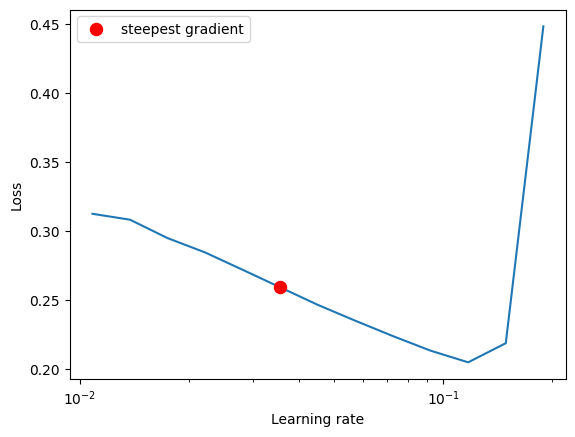

In [9]:
###########################################
# function to find the optimal learning rate
###########################################

# 1) Move model to CPU and build a fresh optimizer (no scheduler metadata)
model_cpu = model.cpu()
optimizer_cpu = torch.optim.AdamW(
    model_cpu.parameters(),
    lr=1e-3,        # placeholder; the finder will override this
    weight_decay=5e-4
)

# 2) Create a tiny DataLoader (batch_size=1) to save memory
small_loader = DataLoader(
    train_loader.dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0
)

# 3) Define an aligned MSE that permutes/expands your [1,1,D] or [D,1,1]
#    target → [D, T, 1] to match output shape exactly.
def aligned_mse(output, target):
    # output: [D, T, 1]
    # target might come in as [D,1,1] or [1,1,D]
    tgt = target

    # Case A: target == [D, 1, 1] → expand middle dim to T
    if tgt.dim() == 3 and tgt.shape[0] == output.shape[0] \
       and tgt.shape[1] == 1 and tgt.shape[2] == 1:
        tgt = tgt.expand(-1, output.size(1), -1)

    # Case B: target == [1, 1, D] → permute to [D,1,1] then expand
    elif tgt.dim() == 3 and tgt.shape[0] == 1 \
         and tgt.shape[1] == 1 and tgt.shape[2] == output.shape[0]:
        # permute (0,1,2) → (2,1,0) to get [D,1,1]
        tgt = tgt.permute(2, 1, 0)
        tgt = tgt.expand(-1, output.size(1), -1)

    else:
        # fallback: broadcast to exactly output.shape
        tgt = tgt.expand(output.shape)

    return Funct.mse_loss(output, tgt)

# 4) Free any lingering GPU memory
gc.collect()
torch.cuda.empty_cache()

# 5) Run the LR‐Finder on CPU for just 30 mini‐batches
lr_finder = LRFinder(
    model_cpu,
    optimizer_cpu,
    aligned_mse,
    device="cpu"
)
lr_finder.range_test(
    small_loader,
    end_lr=1,     # maximum LR to try
    num_iter=30   # number of batches
)
lr_finder.plot()   # examine loss vs. LR curve
lr_finder.reset()  # restore original model & optimizer states

# 6) Move model back to GPU for your main training
model = model_cpu.to("cuda")


Training sees 3776 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.020913


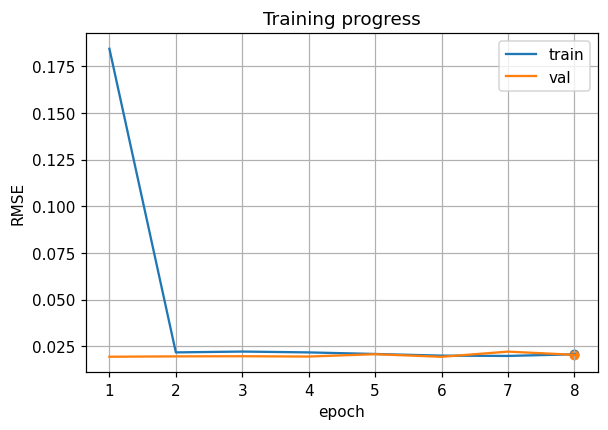

Epoch 1:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 001 • train=0.1844 • val=0.0194 • lr=5.00e-04


Epoch 2:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 002 • train=0.0217 • val=0.0196 • lr=4.99e-04


Epoch 3:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 003 • train=0.0221 • val=0.0196 • lr=4.97e-04


Epoch 4:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 004 • train=0.0217 • val=0.0195 • lr=4.95e-04


Epoch 5:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 005 • train=0.0208 • val=0.0207 • lr=4.92e-04


Epoch 6:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 006 • train=0.0200 • val=0.0193 • lr=4.88e-04


Epoch 7:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 007 • train=0.0198 • val=0.0221 • lr=4.84e-04


Epoch 8:   0%|          | 0/118 [00:00<?, ?bundle/s]

Epoch 008 • train=0.0207 • val=0.0204 • lr=4.79e-04


Epoch 9:   0%|          | 0/118 [00:00<?, ?bundle/s]

In [ ]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")


# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
